In [39]:
from pathlib import Path
import pandas as pd
from datetime import datetime
from dateutil import relativedelta
from sklearn.preprocessing import LabelEncoder

# 1) Load data
lena_path = Path('/home/engaclew/neurogen/lena_metrics.csv')
aclew_path = Path('/home/engaclew/neurogen/aclew_metrics.csv')
children_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings_path = Path('/home/engaclew/DATA/neurogen/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')

lena_data = pd.read_csv(lena_path)
aclew_data = pd.read_csv(aclew_path)
children = pd.read_csv(children_path)
recordings = pd.read_csv(recordings_path)

# 2) Merge data
recordings_data = recordings.merge(children, on='child_id')
recordings_data = recordings_data[~recordings_data['group_id'].isin(['environmental_risk', 'autism_spectrum_disorder'])][['recording_filename', 'group_id']]
lena_data = lena_data.merge(recordings_data, on='recording_filename')
aclew_data = aclew_data.merge(recordings_data, on='recording_filename')

# 3) Replace NaN values
lena_data['avg_voc_dur_mal'].fillna(0, inplace=True)
aclew_data['avg_voc_dur_mal'].fillna(0, inplace=True)
lena_data['peak_1s_CTC'].fillna(0, inplace=True)
aclew_data['peak_1s_CTC'].fillna(0, inplace=True)
lena_data['peak_5s_CTC'].fillna(0, inplace=True)
aclew_data['peak_5s_CTC'].fillna(0, inplace=True)

In [41]:
import scipy.stats as stats

lena_cols = set(lena_data.columns) - set(['recording_filename', 'child_id', 'group_id'])
aclew_cols = set(aclew_data.columns)
print(lena_cols & aclew_cols)
groups = ['low_risk',  'angelman_syndrome',  'down_syndrome', 'fragile_x_syndrome', 'autism_sibling']


rsquare_data = []
for i, metric in enumerate(lena_cols & aclew_cols):
    row = {'metric': metric}
    for group in groups:
        lena_subdata = lena_data[lena_data.group_id == group]
        aclew_subdata = aclew_data[aclew_data.group_id == group]
        slope, intercept, r_value, p_value, std_err = stats.linregress(lena_subdata[metric], aclew_subdata[metric])
        row[group] = 100*r_value
    rsquare_data.append(row)
rsquare_data = pd.DataFrame(rsquare_data)
rsquare_data.set_index('metric', inplace=True)

order = [
    'voc_dur_chi_ph', 'avg_voc_dur_chi', 'voc_chi_ph',
    'voc_dur_fem_ph', 'avg_voc_dur_fem', 'voc_fem_ph', 'wc_fem_ph',
    'voc_dur_mal_ph', 'avg_voc_dur_mal', 'voc_mal_ph', 'wc_mal_ph',
    'wc_adu_ph',
    'voc_dur_och_ph', 'avg_voc_dur_och', 'voc_och_ph',
    '1s_CTC_ph', '5s_CTC_ph',
]

# Reindex the DataFrame with the desired order
rsquare_data = rsquare_data.reindex(order)
print(rsquare_data)

{'wc_mal_ph', 'voc_mal_ph', 'voc_dur_fem_ph', 'voc_dur_och_ph', 'voc_chi_ph', '5s_CTC_ph', 'voc_fem_ph', 'avg_voc_dur_fem', 'voc_och_ph', 'avg_voc_dur_mal', '1s_CTC_ph', 'wc_fem_ph', 'voc_dur_mal_ph', 'voc_dur_chi_ph', 'avg_voc_dur_och', 'avg_voc_dur_chi', 'peak_5s_CTC', 'peak_1s_CTC', 'wc_adu_ph'}
                  low_risk  angelman_syndrome  down_syndrome  \
metric                                                         
voc_dur_chi_ph   87.148753          79.558693      87.071391   
avg_voc_dur_chi  60.539653          65.689206      81.065932   
voc_chi_ph       87.866470          79.571650      89.268184   
voc_dur_fem_ph   86.609357          91.374500      85.128464   
avg_voc_dur_fem  73.960620          80.261990      82.283579   
voc_fem_ph       81.212252          83.976927      78.890170   
wc_fem_ph        88.107268          90.678866      83.093514   
voc_dur_mal_ph   82.124620          84.759441      89.726298   
avg_voc_dur_mal  48.219100          27.657793      46.456745

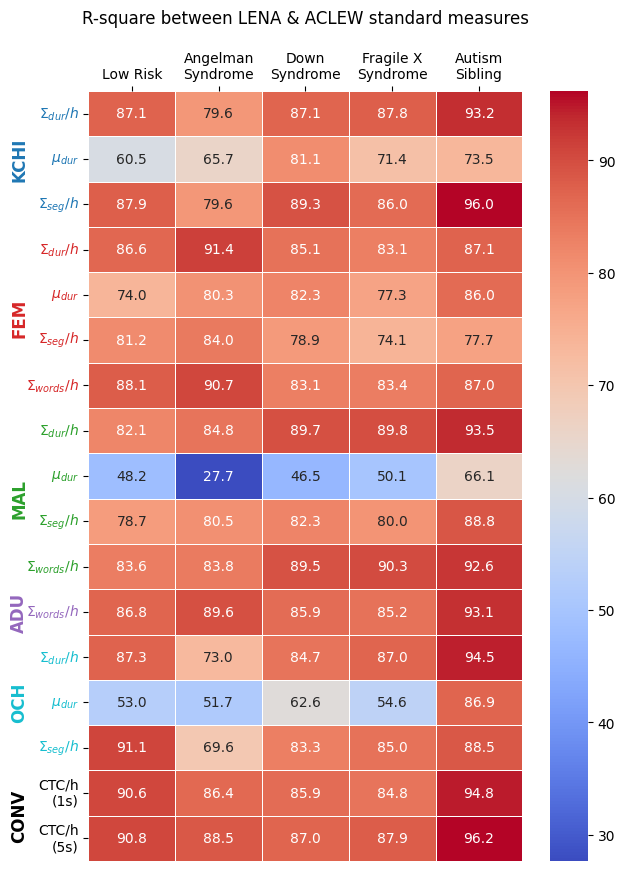

In [52]:
## import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.figure(figsize=(7, 10))
column_labels = ['Low Risk', 'Angelman\nSyndrome', 'Down\nSyndrome', 
                        'Fragile X\nSyndrome', 'Autism\nSibling']
ax = sns.heatmap(rsquare_data, annot=True, cmap='coolwarm', linewidths=.5, fmt='.1f', xticklabels=column_labels)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(ha='center')  # Rotate labels 45 degrees
plt.title('R-square between LENA & ACLEW standard measures', pad=20)

# Trying with custom row labels
row_labels = [r'$\Sigma_{dur}/h$', r'$\mu_{dur}$', '$\Sigma_{seg}/h$', 
              r'$\Sigma_{dur}/h$', r'$\mu_{dur}$', '$\Sigma_{seg}/h$', '$\Sigma_{words}/h$', 
              r'$\Sigma_{dur}/h$', r'$\mu_{dur}$', '$\Sigma_{seg}/h$', '$\Sigma_{words}/h$', '$\Sigma_{words}/h$', 
              r'$\Sigma_{dur}/h$', r'$\mu_{dur}$', '$\Sigma_{seg}/h$',
              'CTC/h\n(1s)', 'CTC/h\n(5s)']
ax.set_yticks(np.arange(len(row_labels)) + 0.5) 
ax.set_yticklabels(row_labels, va='center', ha='right')

row_colors = ['tab:blue', 'tab:blue', 'tab:blue', # KCHI
              'tab:red', 'tab:red', 'tab:red', 'tab:red', # FEM 
              'tab:green', 'tab:green', 'tab:green', 'tab:green', # MAL
              'tab:purple', # adults
              'tab:cyan', 'tab:cyan', 'tab:cyan' # OCH
             ]
for label, color in zip(ax.get_yticklabels(), row_colors):
    label.set_color(color)

ax.text(-.8, 1.5, 'KCHI', rotation=90, va='center', ha='center', fontsize=12, weight='bold', color='tab:blue')
ax.text(-.8, 5, 'FEM', rotation=90, va='center', ha='center', fontsize=12, weight='bold', color='tab:red')
ax.text(-.8, 9, 'MAL', rotation=90, va='center', ha='center', fontsize=12, weight='bold', color='tab:green')
ax.text(-.8, 11.5, 'ADU', rotation=90, va='center', ha='center', fontsize=12, weight='bold', color='tab:purple')
ax.text(-.8, 13.5, 'OCH', rotation=90, va='center', ha='center', fontsize=12, weight='bold', color='tab:cyan')
ax.text(-.8, 16, 'CONV', rotation=90, va='center', ha='center', fontsize=12, weight='bold', color='black')

plt.ylabel('')
plt.savefig(Path('../results/rsquare_metrics/rsquare_lena_aclew.png'), dpi=300)
plt.show()

In [ ]:
plt.plot(lena_data['1s_CTC_